In [1]:
import pandas as pd
import numpy as np

In [2]:
import preprocess
import compress
import search
import index
import score

In [3]:
MIN_TOKENS = 1
DATA_PATH = 'ted_talks.csv'
DATA_COLUMNS = ['description', 'title']  # concatenate these cols together for dataset

In [4]:
df_raw = pd.read_csv(DATA_PATH)

text_raw = pd.Series()
for col in DATA_COLUMNS:
    text_raw = pd.concat([text_raw, df_raw[col]], axis=0, ignore_index=True)

df = pd.DataFrame({
    'text_raw': text_raw,
    'text': text_raw.map(preprocess.preprocess_sentence)
})
df

,text_raw,text
0,Sir Ken Robinson makes an entertaining and pro...,sir ken robinson make entertain profoundli mov...
1,With the same humor and humanity he exuded in ...,humor human exud inconveni truth al gore spell...
2,New York Times columnist David Pogue takes aim...,new york time columnist david pogu take aim te...
3,"In an emotionally charged talk, MacArthur-winn...",emot charg talk macarthur-win activist majora ...
4,You've never seen data presented like this. Wi...,never seen data present like drama urgenc spor...
...,...,...
5095,What we're missing in the debate about immigra...,we'r miss debat immigr
5096,The most Martian place on Earth,martian place earth
5097,What intelligent machines can learn from a sch...,intellig machin learn school fish
5098,A black man goes undercover in the alt-right,black man goe undercov alt-right


In [5]:
_df = df.copy()
_df['tokens'] = df['text'].map(preprocess.tokenize)
_df['n_tokens'] = _df['tokens'].map(len)
_df['n_chars'] = _df['text'].str.replace(' ', '').str.len()

df = df[_df['n_tokens'] >= MIN_TOKENS]
df

,text_raw,text
0,Sir Ken Robinson makes an entertaining and pro...,sir ken robinson make entertain profoundli mov...
1,With the same humor and humanity he exuded in ...,humor human exud inconveni truth al gore spell...
2,New York Times columnist David Pogue takes aim...,new york time columnist david pogu take aim te...
3,"In an emotionally charged talk, MacArthur-winn...",emot charg talk macarthur-win activist majora ...
4,You've never seen data presented like this. Wi...,never seen data present like drama urgenc spor...
...,...,...
5095,What we're missing in the debate about immigra...,we'r miss debat immigr
5096,The most Martian place on Earth,martian place earth
5097,What intelligent machines can learn from a sch...,intellig machin learn school fish
5098,A black man goes undercover in the alt-right,black man goe undercov alt-right


In [6]:
df.reset_index(drop=True, inplace=True)
df.to_csv('data.csv', index=False)
df

,text_raw,text
0,Sir Ken Robinson makes an entertaining and pro...,sir ken robinson make entertain profoundli mov...
1,With the same humor and humanity he exuded in ...,humor human exud inconveni truth al gore spell...
2,New York Times columnist David Pogue takes aim...,new york time columnist david pogu take aim te...
3,"In an emotionally charged talk, MacArthur-winn...",emot charg talk macarthur-win activist majora ...
4,You've never seen data presented like this. Wi...,never seen data present like drama urgenc spor...
...,...,...
5093,What we're missing in the debate about immigra...,we'r miss debat immigr
5094,The most Martian place on Earth,martian place earth
5095,What intelligent machines can learn from a sch...,intellig machin learn school fish
5096,A black man goes undercover in the alt-right,black man goe undercov alt-right


<Axes: ylabel='Frequency'>

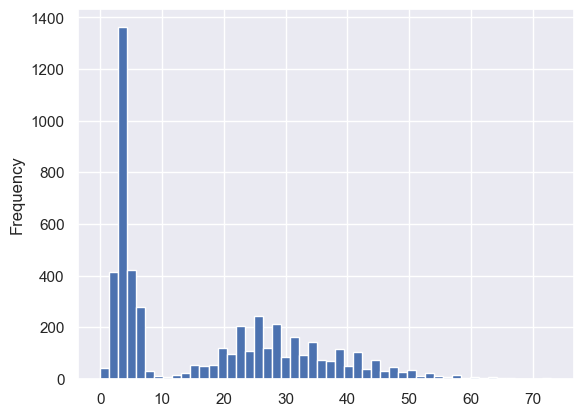

In [7]:
_df['n_tokens'].plot.hist(bins=50)

In [8]:
documents = _df['tokens'].tolist()

In [9]:
positional = index.PositionalIndex()
positional.add_documents(documents)
positional.save('positional-index.json')

In [10]:
non_positional = index.NonPositionalIndex()
non_positional.add_documents(documents)
non_positional.save('non-positional-index.json')

### Evaluate

#### Index Evaluating

In [11]:
term = input('Enter a term to check: ')
positional.view_term(term)
print()
non_positional.view_term(term)

Positional Index (sir)
Doc-ID | [Term-IDs]
1 | [0]
55 | [6]
693 | [6]
834 | [3]
1503 | [0]
1803 | [0]

Non-Positional Index (sir)
Doc-IDs: [1, 55, 693, 834, 1503, 1803]



#### Compression Evaluating

In [12]:
indexes = non_positional.get_term(term)
print('Numbers:', indexes)

binarized = list(map(compress.binary, indexes))
variable_code = list(map(compress.variable_byte, indexes))
gamma_code = list(map(compress.gamma, indexes))

print('\nBinary Form')
print('Primary:', binarized)
print('Variable Byte:', variable_code)
print('Gamma Code:', gamma_code)

print('\nSize (bits)')
print('Primary:', sum(map(compress.get_size, binarized)))
print('Variable Byte:', sum(map(compress.get_size, variable_code)))
print('Gamma Code:', sum(map(compress.get_size, gamma_code)))

Numbers: [1, 55, 693, 834, 1503, 1803]

Binary Form
Primary: ['1', '110111', '1010110101', '1101000010', '10111011111', '11100001011']
Variable Byte: ['10000001', '10110111', '1000010101010110', '1000001001101000', '1000111101011101', '1000101101110000']
Gamma Code: ['0', '11111010111', '1111111110010110101', '1111111110101000010', '111111111100111011111', '111111111101100001011']

Size (bits)
Primary: 49
Variable Byte: 80
Gamma Code: 92


#### Search & Score Evaluating

In [13]:
query = preprocess.preprocess_sentence(input("Enter the query for search: "), return_token=True)
formatted_query = positional.format_query(query)
valid_query = list(positional.validate_terms(formatted_query))

print('Entered Query: ', query)
print('Formatted Query: ', formatted_query)
print('Processed Query: ', valid_query)

doc_ids = positional.search(valid_query, n=10)
docs = list(map(positional.fetch_id, doc_ids))
doc_scores = [positional.score(doc, valid_query) for doc in docs]
print('Search Result (ID: Score  # Document)')
for _id, _doc, _score in zip(doc_ids, docs, doc_scores):
    print(_id, ': ', _score, '  #', _doc)

Entered Query:  ['sir']
Formatted Query:  ['sir']
Processed Query:  ['sir']
Search Result (ID: Score  # Document)
1 :  0.3163754   # ['sir', 'ken', 'robinson', 'make', 'entertain', 'profoundli', 'move', 'case', 'creat', 'educ', 'system', 'nurtur', 'rather', 'undermin', 'creativ']
55 :  0.26920357   # ['speak', 'astronom', 'concern', 'member', 'human', 'race', 'sir', 'martin', 'ree', 'examin', 'planet', 'futur', 'cosmic', 'perspect', 'urg', 'action', 'prevent', 'dark', 'consequ', 'scientif', 'technolog', 'develop']
693 :  0.2640469   # ['poignant', 'funni', 'follow-up', 'fabl', '2006', 'talk', 'sir', 'ken', 'robinson', 'make', 'case', 'radic', 'shift', 'standard', 'school', 'person', 'learn', 'creat', 'condit', 'kid', 'natur', 'talent', 'flourish']
1503 :  0.24579747   # ['sir', 'ken', 'robinson', 'outlin', '3', 'principl', 'crucial', 'human', 'mind', 'flourish', 'current', 'educ', 'cultur', 'work', 'funni', 'stir', 'talk', 'tell', 'us', 'get', 'educ', 'death', 'valley', 'face', 'nurtur

In [14]:
ap = positional.average_precision(docs, query, minimum=0, maximum=1)
print('The AP value of above query and documents:', ap)

The AP value of above query and documents: 0.2566798


In [15]:
idx = 0
doc_id = doc_ids[idx]
doc = docs[idx]
print('Doc-ID:', doc_id)
print('Document:', doc)
print('Query:', query)

Doc-ID: 1
Document: ['sir', 'ken', 'robinson', 'make', 'entertain', 'profoundli', 'move', 'case', 'creat', 'educ', 'system', 'nurtur', 'rather', 'undermin', 'creativ']
Query: ['sir']


In [16]:
matrix = positional.steps_matrix(doc, query)
print('Score (sum of prods): ', matrix['prod'].sum())
matrix

Score (sum of prods):  0.31637540797060915


Query                                     Document             \
              tf tf-wt   df       idf        wt   nz       tf tf-wt   df   
terms                                                                      
sir            1   1.0    6  2.929419  2.929419  1.0        1   1.0    6   
ken            0   0.0    7  2.862472  0.000000  0.0        1   1.0    7   
robinson       0   0.0    7  2.862472  0.000000  0.0        1   1.0    7   
make           0   0.0  469  1.036397  0.000000  0.0        1   1.0  469   
entertain      0   0.0   22  2.365147  0.000000  0.0        1   1.0   22   
profoundli     0   0.0    4  3.105510  0.000000  0.0        1   1.0    4   
move           0   0.0  115  1.646872  0.000000  0.0        1   1.0  115   
case           0   0.0  102  1.698970  0.000000  0.0        1   1.0  102   
creat          0   0.0  206  1.393703  0.000000  0.0        1   1.0  206   
educ           0   0.0   76  1.826757  0.000000  0.0        1   1.0   76   
system         0   0.0  103  1.694733  0.000000  0.0        1   1.0  103   
nurtur         0   0.0    5  3.008600  0.000000  0.0        1   1.0    5   
rather         0   0.0   30  2.230449  0.000000  0.0        1   1.0   30   
undermin       0   0.0    1  3.707570  0.000000  0.0        1   1.0    1   
creativ        0   0.0   99  1.711935  0.000000  0.0        1   1.0   99   

                                              prod  
                 idf        wt        nz            
terms                                               
sir         2.929419  2.929419  0.316375  0.316375  
ken         2.862472  2.862472  0.309145  0.000000  
robinson    2.862472  2.862472  0.309145  0.000000  
make        1.036397  1.036397  0.111930  0.000000  
entertain   2.365147  2.365147  0.255434  0.000000  
profoundli  3.105510  3.105510  0.335393  0.000000  
move        1.646872  1.646872  0.177861  0.000000  
case        1.698970  1.698970  0.183488  0.000000  
creat       1.393703  1.393703  0.150519  0.000000  
educ        1.826757  1.826757  0.197289  0.000000  
system      1.694733  1.694733  0.183030  0.000000  
nurtur      3.008600  3.008600  0.324927  0.000000  
rather      2.230449  2.230449  0.240887  0.000000  
undermin    3.707570  3.707570  0.400415  0.000000  
creativ     1.711935  1.711935  0.184888  0.000000